In [2]:
# fmt: off
import numpy as np
import matplotlib.pyplot as plt
from Interpretability.InterpretabilityMethods import *
from SequentialLearning.SequentialTask import *
from SequentialLearning.EWC_Methods.EWC_Methods import *

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# fmt: on

In [29]:
MODEL_SAVE_PATH = "models/mnist_intepretability_model"
TRAIN_MODEL = True
LOAD_MODEL = False

task_digit_labels = [0,1]
epochs = 5
training_batches = 300
validation_batches = 100
batch_size = 32
ewc_method = EWC_Method.NONE

In [31]:
model: tf.keras.Model
if LOAD_MODEL and os.path.exists(MODEL_SAVE_PATH):
    # Try to load model directly, if one exists
    print("LOADING MODEL")
    model = tf.keras.models.load_model(MODEL_SAVE_PATH,compile=False)  # type: ignore
else:
    # Otherwise, make an entire new model!
    print("CREATING MODEL")
    model_input_shape = (28,28,1)
    model_inputs = model_layer = tf.keras.Input(shape=model_input_shape)
    model_layer = tf.keras.layers.Conv2D(12, (5,5), activation="relu")(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(12, (4,4), activation="relu")(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(12, (4,4), activation="relu")(model_layer)
    model_layer = tf.keras.layers.Flatten()(model_layer)
    model_layer = tf.keras.layers.Dense(10, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dense(len(task_digit_labels))(model_layer)
    model_layer = tf.keras.layers.Activation("linear")(model_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=model_layer, name="model")

if len(task_digit_labels) == 2:
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.summary()

CREATING MODEL
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 12)        312       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 12)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 12)          2316      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 12)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 12) 

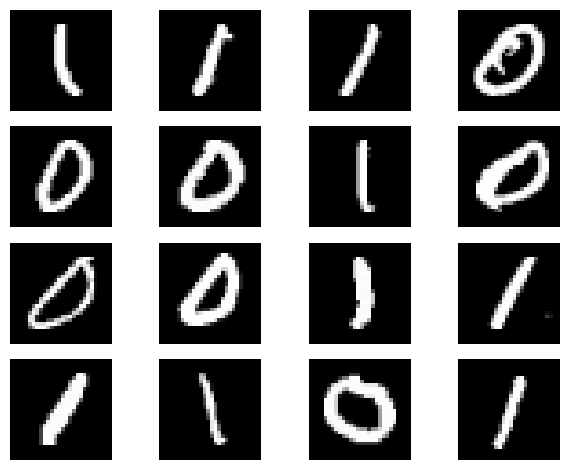

In [32]:
task = MNISTClassificationTask(
        name=f"Task 0",
        model=model,
        model_base_loss=loss_fn,
        task_digit_labels=task_digit_labels,
        training_batches = training_batches,
        validation_batches = validation_batches,
        batch_size=batch_size
    )
task.compile_model(loss_fn)

# Show some images from the task dataset
batch = task.training_dataset.take(1).get_single_element()
images = batch[0][:16]
plot_images(images, cmap="gray")

In [33]:
if TRAIN_MODEL:
    checkpoint_path = MODEL_SAVE_PATH+"/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1)
    history = task.train_on_task(epochs=epochs, callbacks=[
        # checkpoint_callback,
    ])
    model.save(MODEL_SAVE_PATH)

Epoch 1/5
300/300 [==============================] - 19s 56ms/step - loss: 0.0658 - base_loss: 0.0658 - val_loss: 0.0052 - val_base_loss: 0.0052
Epoch 2/5
300/300 [==============================] - 17s 56ms/step - loss: 0.0028 - base_loss: 0.0028 - val_loss: 0.0022 - val_base_loss: 0.0022
Epoch 3/5
300/300 [==============================] - 17s 57ms/step - loss: 0.0019 - base_loss: 0.0019 - val_loss: 0.0031 - val_base_loss: 0.0031
Epoch 4/5
300/300 [==============================] - 17s 55ms/step - loss: 0.0021 - base_loss: 0.0021 - val_loss: 0.0022 - val_base_loss: 0.0022
Epoch 5/5
300/300 [==============================] - 17s 55ms/step - loss: 0.0011 - base_loss: 0.0011 - val_loss: 0.0014 - val_base_loss: 0.0014


INFO:tensorflow:Assets written to: models/mnist_intepretability_model/assets


INFO:tensorflow:Assets written to: models/mnist_intepretability_model/assets


conv2d_5



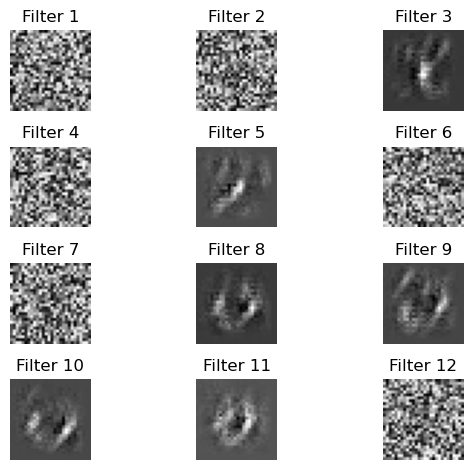

In [34]:
kernel_inspection(model=task.model, layer_index=5, steps=1000, step_size=0.05)

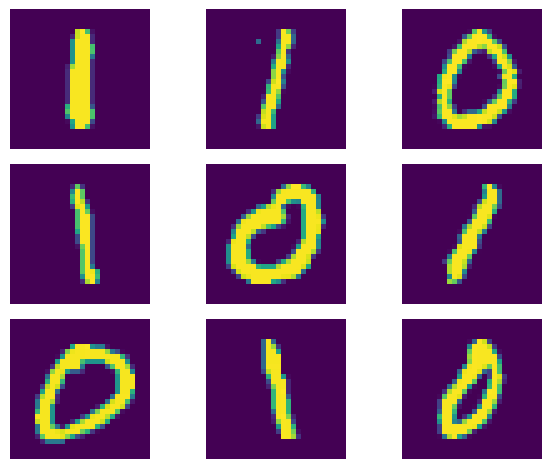

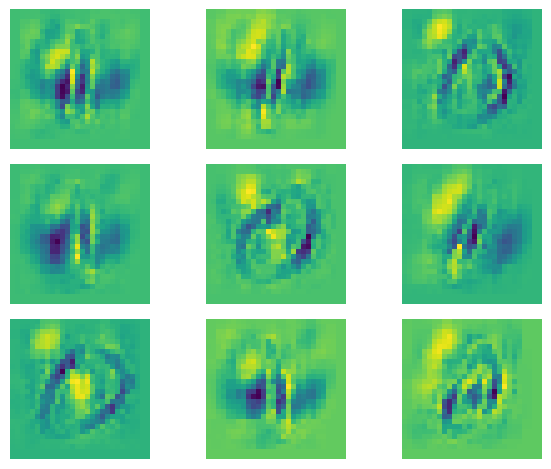

In [18]:
data = task.validation_dataset.take(1)
occlusion_sensitivity(task.model, data,num_items=9, patch_size=1, stride=1)